# SVDD

## Libraries to import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from tqdm import tqdm
import pickle
# %matplotlib inline

import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Conv2D, Input
from keras.datasets import mnist
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler 

sys.path.append("/homes/lexjohan/Documents/EME/SVDD/")
from dataloader import unpack, unpack_ordered, unpack_polina
from modeldefault import VariationalAutoencoderModel

sys.path.append('/homes/lexjohan/Documents/models')
os.path.join("nxsdk_modules_ncl/snntoolbox")
from nxsdk_modules_ncl.dnn.src.utils import extract, to_integer
from nxsdk_modules_ncl.dnn.src.dnn_layers import NxInputLayer, NxDense, \
    NxModel, ProbableStates
from nxsdk_modules_ncl.dnn.composable.composable_dnn import ComposableDNN as DNN
from nxsdk_modules_ncl.input_generator.input_generator import InputGenerator
import nxsdk
from nxsdk.composable.model import Model
from nxsdk.logutils.nxlogging import set_verbosity,LoggingLevel
from nxsdk.api.enums.api_enums import ProbeParameter
from nxsdk.graph.monitor.probes import PerformanceProbeCondition

2023-01-08 15:29:31.241731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 15:29:31.584939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /slurm/intel-archi/lib
2023-01-08 15:29:31.584961: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-08 15:29:33.238781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared obj

## Setting environment variables

In [2]:
# Enable SLURM to run network on Loihi.
os.environ['SLURM'] = '1'
os.environ['PYTHONUNBUFFERED'] = '1'

os.environ["PARTITION"] = "nahuku32_2h"
os.environ["BOARD"] = 'ncl-ext-ghrd-01'

## Load data

In [3]:
mode = 'ordered' #mode = 'polina' / mode = 'None'
Flags = None

data_path = "../EME/SVDD/data/"

train_path = data_path + "training.h5"
test_path = data_path + "testing.h5"

if mode == 'ordered':
    _, regression = unpack_ordered(train_path, Flags)
elif mode == 'polina':
    _, num_objects, regression = unpack_polina(train_path, Flags)
else:
    #load training and validation data
    _, num_objects, regression, classification = unpack(train_path, Flags)

scaler = StandardScaler()

scaler.fit(regression)
reg_normalized = scaler.transform(regression)

if mode == 'ordered':
    training_data = reg_normalized[:]
elif mode == 'polina':
    training_data = [num_objects[:], reg_normalized[:]]
else:
    training_data = [classification[:], reg_normalized[:]]

dataset_len = regression.shape[0]
if mode == 'ordered' or mode == 'polina':
    data_dim = regression.shape[1]
else:
    data_dim = classification.shape[1]


  0%|          | 0/1 [00:00<?, ?it/s]

Unpacking file ../EME/SVDD/data/training.h5


event type int8 (3600000,) 3.6 MB
regression float32 (3600000, 76) 1094.4 MB


In [4]:
training_data.shape

(3600000, 76)

## Setup model

In [5]:
models_path = "../EME/SVDD/optimized_W/"

models = os.listdir(models_path)
model_name = models[0]
dim_z = int(model_name.split("zdim")[1].split(".")[0].split("_")[1])
ft = 0

hidden_layers = [512, 256, 128]

ann_model = VariationalAutoencoderModel(hidden_layers, model_name, data_dim, dataset_len, dim_z, ft, mode=mode, verbose=True)
ann_model.load_weights(models_path + model_name)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in_regression (InputLayer)  [(None, 76)]              0         
                                                                 
 dense (Dense)               (None, 512)               39424     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 z_mean (Dense)              (None, 21)                2709      
                                                                 
Total params: 206,357
Trainable params: 206,357
Non-trainable params: 0
_________________________________________________________________


2023-01-08 15:30:03.123098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /slurm/intel-archi/lib
2023-01-08 15:30:03.123121: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 15:30:03.123136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ncl-edu): /proc/driver/nvidia/version does not exist
2023-01-08 15:30:03.123337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create SNN

In [6]:
vth_mant = 2**9
bias_exp = 6
weight_exponent = 0
synapse_encoding = 'sparse'

in_regression = NxInputLayer(data_dim,
                            vThMant=vth_mant,
                            biasExp=bias_exp)

layer = NxDense(hidden_layers[0])(in_regression.input)
for idx in range(1, len(hidden_layers)):
    layer = NxDense(hidden_layers[idx])(layer)

layer = NxDense(dim_z)(layer)
snn_nxmodel = NxModel(in_regression.input, layer)
snn_nxmodel.summary()

Model: "nx_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (NxInputLayer)      (None, 76)                0         
                                                                 
 nx_dense (NxDense)          (None, 512)               39424     
                                                                 
 nx_dense_1 (NxDense)        (None, 256)               131328    
                                                                 
 nx_dense_2 (NxDense)        (None, 128)               32896     
                                                                 
 nx_dense_3 (NxDense)        (None, 21)                2709      
                                                                 
Total params: 206,357
Trainable params: 206,357
Non-trainable params: 0
_________________________________________________________________


## Convert weights

In [7]:
# Extract weights and biases from parameter list.
parameters = ann_model.model.get_weights()
weights = parameters[0::2]
biases = parameters[1::2]

# Quantize weights and biases using max-normalization (Strong quantization loss if distributions have large tails)
parameters_int = []
for w, b in zip(weights, biases):
    w_int, b_int = to_integer(w, b, 8)
    parameters_int += [w_int, b_int]

# Set quantized weigths and biases for spiking model
snn_nxmodel.set_weights(parameters_int)

## Plot weights

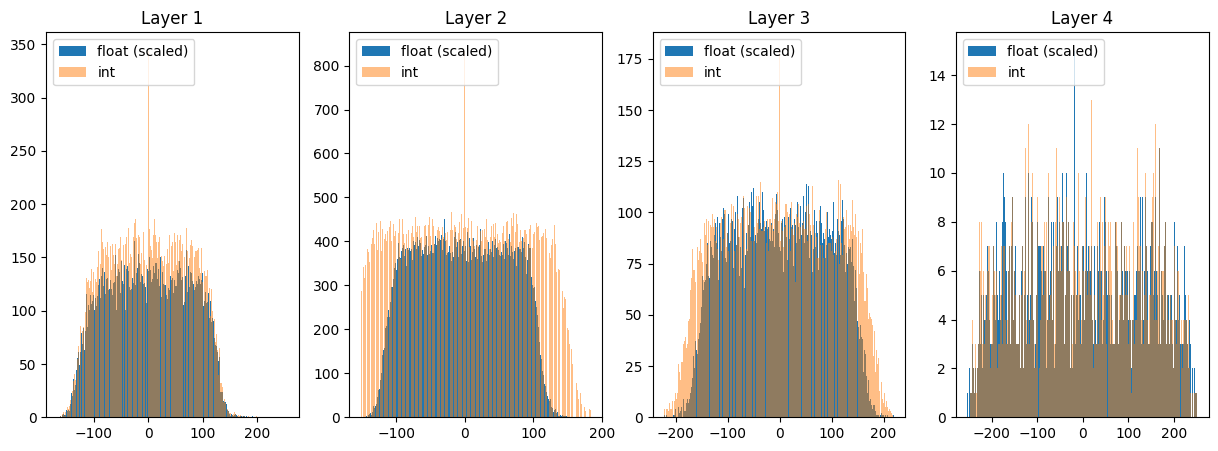

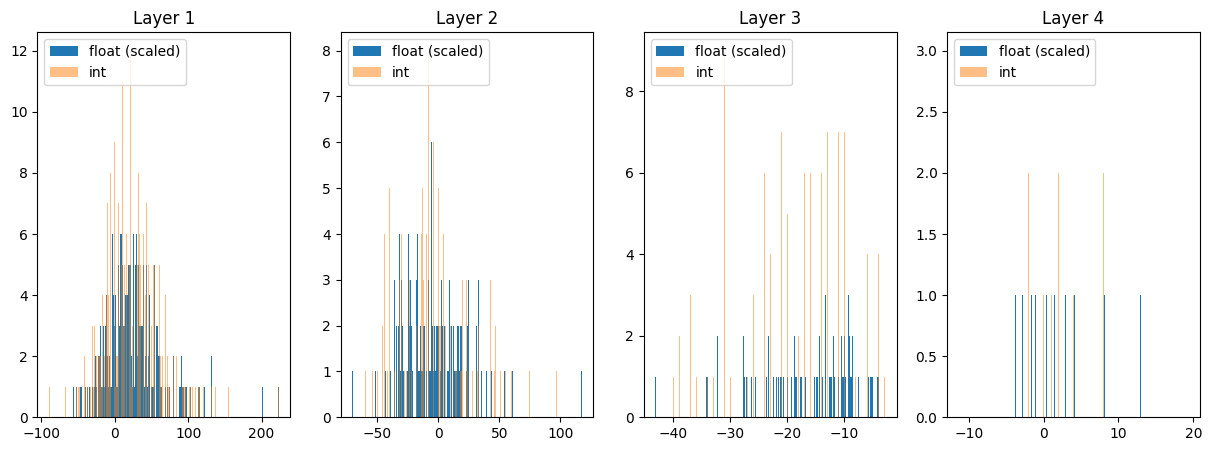

In [8]:
%matplotlib inline

def plotParamDist(params, params_int, max_val, num_bins=64):
    num_layers = len(params)
    for i, (p1, p2) in enumerate(zip(params, params_int)):
        plt.subplot(1, num_layers, i+1)
        scaled_p = np.ndarray.flatten(p1/max_val*255)
        _, bins, _ = plt.hist(scaled_p, bins=num_bins, label='float (scaled)')
        _ = plt.hist(np.ndarray.flatten(p2), bins=bins, alpha=0.5, label='int')
        plt.title("Layer {}".format(i+1))
        plt.legend(loc='upper left')

weights_int = parameters_int[0::2]
biases_int = parameters_int[1::2]
max_val = [np.max(np.abs(np.concatenate([w, b], None))) for w, b in zip(weights, biases)]
max_val = np.max(max_val)

plt.figure(figsize=(15,5))
plotParamDist(weights, weights_int, max_val, num_bins=512)
plt.show()

plt.figure(figsize=(15,5))
plotParamDist(biases, biases_int, max_val, num_bins=512)
plt.show()

## Convert SNN model

In [9]:
num_steps_per_img = 25
data_dim_snn = (data_dim, )

# NxModel is not yet implemented as a Composable -> Wrap it with DNN composable class
dnn = DNN(model=snn_nxmodel, num_steps_per_img=num_steps_per_img)

input_generator = InputGenerator(shape=data_dim_snn, interval=num_steps_per_img)
input_generator.setBiasExp(bias_exp)

set_verbosity(LoggingLevel.ERROR)

# Initialize empty model
snn_model = nxsdk.composable.model.Model("dnn_model")

# Add DNN and InputGenerator to empty model
snn_model.add(dnn)
snn_model.add(input_generator)


# Connect InputGenerator to DNN
# (Explicit)
# input_generator.ports.output.connect(dnn.ports.input)
# (Implicit when ports can be inferred)
input_generator.connect(dnn)

# Enfore particular execution order or processes/snips executing in the same phase
# (Here: Execute input injection as bias currents after network reset)
input_generator.processes.inputEncoder.executeAfter(dnn.processes.reset)
snn_model.compile()

x

x

..x

x

x



## Create energy probe

In [10]:
data_split = 0.01
num_test_samples = int(training_data.shape[0] * data_split)
execution_time_probe_bin_size = 512 # Small numbers slows down execution

eProbe = snn_model.board.probe(
    probeType=ProbeParameter.ENERGY, 
    probeCondition=PerformanceProbeCondition(
        tStart=1, 
        tEnd=num_test_samples*num_steps_per_img, 
        bufferSize=1024, 
        binSize=execution_time_probe_bin_size))

snn_model.start(snn_nxmodel.board)

## Run SNN model

In [11]:
def run_model(num_steps_per_sample, train_data):
    batch_size = 64
    num_samples = train_data.shape[0]
    print("num_samples: {}".format(num_samples))
    print(f"time steps: {num_steps_per_sample * num_samples}")

    print("starting model run")
    tStart = time.time()
    snn_model.run(num_steps_per_sample * num_samples, aSync=True)
    tEndBoot = time.time()

    print("queueing data in input generator")
    with tqdm(total=num_samples) as pbar:
        for idx in range(0, num_samples, batch_size):
            batch = train_data[idx:idx+batch_size]
            b = np.abs(np.rint(batch).astype(int))
            input_generator.batchEncode(b)
            pbar.update(batch_size)

    tEndInput = time.time()
    print("Reading out channels")

    out = list(dnn.readout_channel.read(num_samples))
    tEndClassification = time.time()

    print("Finishing model run")
    snn_model.finishRun()
    
    return tStart, tEndBoot, tEndInput, tEndClassification, out

# 1 percent of training_data
tStart, tEndBoot, tEndInput, tEndClassification, out = run_model(num_steps_per_img, training_data[:num_test_samples])

snn_model.disconnect()

# tStart, tEndBoot, tEndInput, tEndClassification = run_model(num_steps_per_img, training_data)


num_samples: 36000
time steps: 900000
starting model run
queueing data in input generator


36032it [00:44, 802.59it/s]                           


Reading out channels
Finishing model run


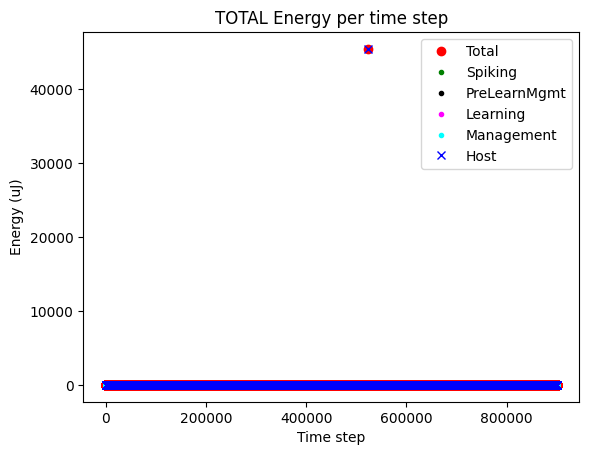

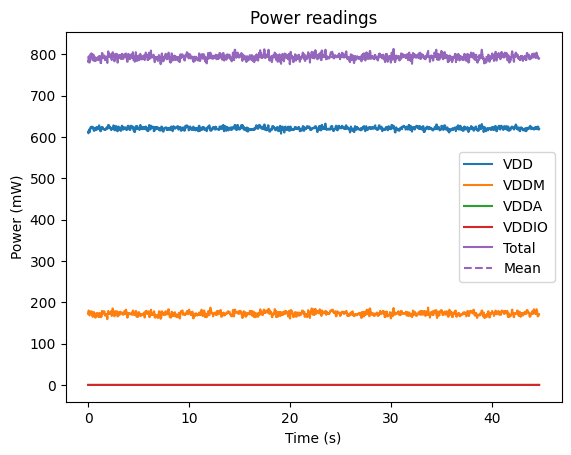

In [12]:
%matplotlib inline
eProbe.plotEnergy()
plt.show()

eProbe.plotPower()
plt.show()

In [13]:
print(f"Total Energy used: {eProbe.totalEnergy}{eProbe.energyUnits}")

Total Energy used: 35447359.5300621uJ


In [14]:
# Runtime statistics
runtimeBoot = tEndBoot-tStart
runtimeInput = tEndInput-tStart
runtimeClassification = tEndClassification-tStart
print("Runtime statistics including boot, input generation and classification:")
print("-----------------------------------------------------------------------")
print("    Runtime till end of boot: {:.3f} s".format(runtimeBoot))
print("    Runtime till end of input queueing: {:.3f} s".format(runtimeInput))
print("    Runtime till end of classification: {:.3f} s".format(runtimeClassification))
print("    Effective average time per time step: %.3fus"%(runtimeClassification*1e6/(num_test_samples*num_steps_per_img)))
print("    Effective average classification time per sample: %.3fms"%(runtimeClassification*1e3/num_test_samples))
print("")

Runtime statistics including boot, input generation and classification:
-----------------------------------------------------------------------
    Runtime till end of boot: 0.372 s
    Runtime till end of input queueing: 45.268 s
    Runtime till end of classification: 45.392 s
    Effective average time per time step: 50.436us
    Effective average classification time per sample: 1.261ms



In [15]:
def get_methods(object, spacing=20):
  methodList = []
  for method_name in dir(object):
    try:
        if callable(getattr(object, method_name)):
            methodList.append(str(method_name))
    except Exception:
        methodList.append(str(method_name))
  processFunc = (lambda s: ' '.join(s.split())) or (lambda s: s)
  for method in methodList:
    try:
        print(str(method.ljust(spacing)) + ' ' +
              processFunc(str(getattr(object, method).__doc__)[0:90]))
    except Exception:
        print(method.ljust(spacing) + ' ' + ' getattr() failed')

get_methods(eProbe)

EnergyPhase          Enumeration of various energy phases
EnergyType           Enumeration of various energy types
_EnergyPhaseEnum     Enumeration of various energy phases
_EnergyTypeEnum      Enumeration of various energy types
__class__            A probe that allows to measure the power and energy per algorithmic time step.
__delattr__          Implement delattr(self, name).
__dir__              Default dir() implementation.
__eq__               Return self==value.
__format__           Default object formatter.
__ge__               Return self>=value.
__getattribute__     Return getattr(self, name).
__gt__               Return self>value.
__hash__             Return hash(self).
__init__             None
__init_subclass__    This method is called when a class is subclassed. The default implementation does nothing
__le__               Return self<=value.
__lt__               Return self<value.
__ne__               Return self!=value.
__new__              Create and return a new objec

_EnergyPhaseEnum.MANAGEMENT


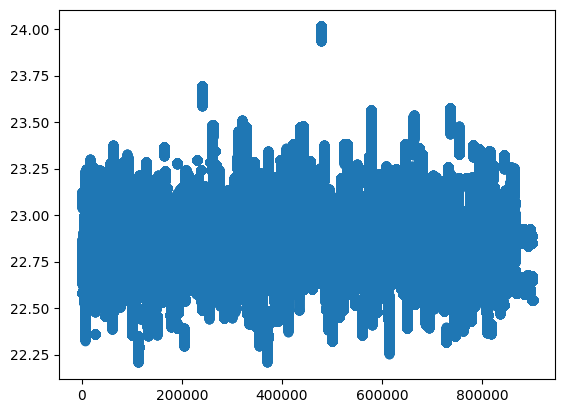

In [16]:
phase = eProbe.EnergyPhase(3)
t = eProbe.EnergyType(4)
energy = eProbe._energyArray(t, phase)

print(phase)
plt.scatter(x=np.arange(len(energy)), y=energy)


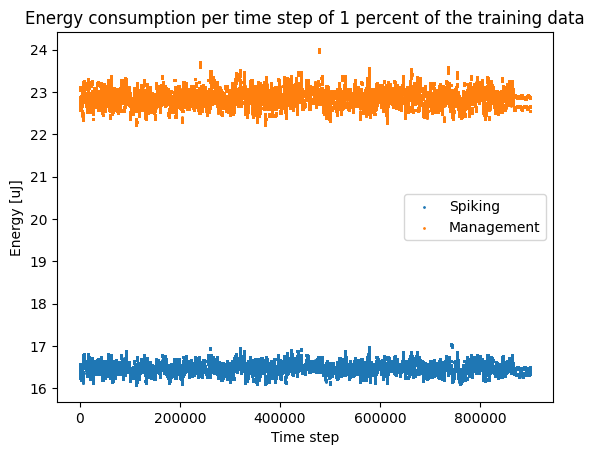

In [17]:
phases = [eProbe.EnergyPhase(0), eProbe.EnergyPhase(3)]
labels = ["Spiking", "Management"]
eType = eProbe.EnergyType(4)

for idx, phase in enumerate(phases):
    energy = eProbe._energyArray(eType, phase)
    plt.scatter(x=np.arange(len(energy)), y=energy, label=labels[idx], s=1)

plt.xlabel("Time step")
plt.ylabel("Energy [uJ]")
plt.title("Energy consumption per time step of 1 percent of the training data")
plt.legend()
plt.show()

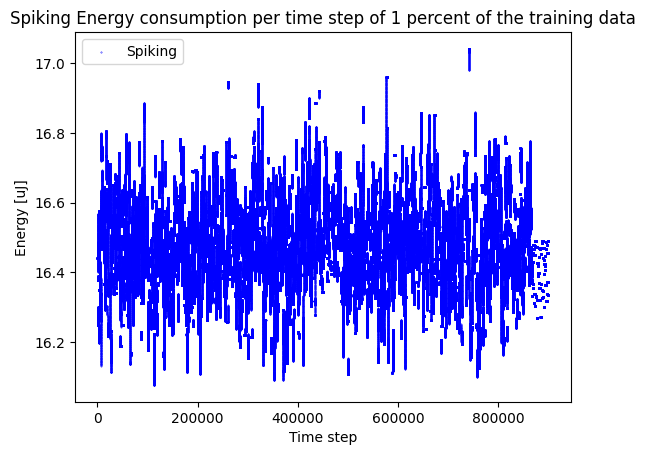

In [18]:
spiking_phase = eProbe.EnergyPhase(0)

energy = eProbe._energyArray(eType, spiking_phase)

plt.scatter(x=np.arange(len(energy)), y=energy, s=0.1, c="blue", label="Spiking")
plt.xlabel("Time step")
plt.ylabel("Energy [uJ]")
plt.title("Spiking Energy consumption per time step of 1 percent of the training data")
plt.legend()
plt.show()

In [19]:
print(f"Total Energy used: {eProbe.totalEnergy}{eProbe.energyUnits}")

Total Energy used: 35447359.5300621uJ


In [22]:
print(type(out))

<class 'list'>


In [24]:
#save results
results_path = "results/"
if not os.path:
    os.mkdir(results_path)

with open(results_path+f'output_{dim_z}.pkl', 'wb') as f:
    np.save(f, np.array(out))

energy_dict = dict()
energy_dict['tStart'] = tStart
energy_dict['tEndBoot'] = tEndBoot
energy_dict['tEndInput'] = tEndInput
energy_dict['tEndClassification'] = tEndClassification
energy_dict['totalEnergy'] = eProbe.totalEnergy
energy_dict['energyUnits'] = eProbe.energyUnits

#save energy
with open(results_path+f'energy_{dim_z}.pkl', 'wb') as f:
    pickle.dump(energy_dict, f)